## 1. State
first define the state of the graph

In [1]:
from typing_extensions import TypedDict

class State(TypedDict):
    graph_state: str

## 2.Nodes

2.1 nodes are just python functions

2.2 The first positional argument is the state, as defined above.

2.3 Each node returns a new value of the state key graph_state.

In [2]:
def node_1(state):
    print("---Node 1---")
    return {"graph_state": state['graph_state'] +" I am"}

def node_2(state):
    print("---Node 2---")
    return {"graph_state": state['graph_state'] +" Hansidu"}

def node_3(state):
    print("---Node 2---")
    return {"graph_state": state['graph_state'] +" Dahami"}

## 3.Edges

Edges connect the nodes.

- Conditional edges are implemented as functions that return the next node to visit based upon some logic.

In [ ]:
import random
from typing import Literal

def decide_who(state) -> Literal["node_2","node_3"]:
    # condition to go to the node 2 or 3
    # for simple illustration use random number 
    # and go to the node based on value grater than 0.5
    val = random.random() 
    if val >= 0.5:
        return "node_2"
    else:
        return "node_3"

## 4. Graph Construction

4.1 The StateGraph class is the graph class that we can use.

4.2 First, we initialize a StateGraph with the State class we defined above.

4.3 We use the START Node, a special node that sends user input to the graph, to indicate where to start our graph.

4.4 The END Node is a special node that represents a terminal node.

4.5 Then compile the graph

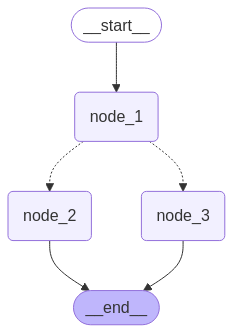

In [4]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

builder = StateGraph(State)

# add the  nodes
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# add the edges
builder.add_edge(START,"node_1")
builder.add_conditional_edges("node_1",decide_who)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# compile the graph
graph = builder.compile()

# view the compiled graph
display(Image(graph.get_graph().draw_mermaid_png()))

## 5. Graph Invocation

The compiled graph implements the runnable protocol.

So we have to call the invoke method to run the graph

In [19]:
graph.invoke({"graph_state" : "Hi!"})

---Node 1---
---Node 2---


{'graph_state': 'Hi! I am Dahami'}

## 6. Make an react agent

We built a router.

- Our chat model will decide to make a tool call or not based upon the user input
- We use a conditional edge to route to a node that will call our tool or simply end

In [20]:
import getpass
import os

if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Google AI API key: ")

In [21]:
# make the tools that the agent can call
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]

In [22]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash-001",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)
llm_with_tools = llm.bind_tools(tools)

Create the system prompt that describe the overall behavior of the chat model.

In [23]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

In [24]:
# create a node of chat model
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

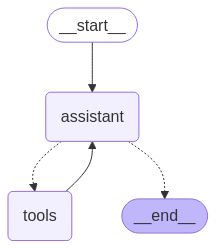

In [25]:
# make the graph
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# show the graph
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [26]:
messages = [HumanMessage(content="hi!")]
messages = react_graph.invoke({"messages": messages})

for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

hi!
================================== Ai Message ==================================

Hi there! How can I help you today?


In [28]:
messages = [HumanMessage(content="calculate 2+2 and multiply by 345")]
messages = react_graph.invoke({"messages": messages})

for message in messages['messages']:
    message.pretty_print()

================================ Human Message =================================

calculate 2+2 and multiply by 345
================================== Ai Message ==================================
Tool Calls:
  add (426f261a-20b5-4300-9863-f3f5e8644971)
 Call ID: 426f261a-20b5-4300-9863-f3f5e8644971
  Args:
    a: 2.0
    b: 2.0
================================= Tool Message =================================
Name: add

4
================================== Ai Message ==================================
Tool Calls:
  multiply (f5e767be-9b8d-479f-aa71-0165fbd3a7e3)
 Call ID: f5e767be-9b8d-479f-aa71-0165fbd3a7e3
  Args:
    a: 4.0
    b: 345.0
================================= Tool Message =================================
Name: multiply

1380
================================== Ai Message ==================================

2+2 is 4, and 4 multiplied by 345 is 1380.


## 7. Add Memory